<a href="https://colab.research.google.com/github/nedokormysh/Stepik_AI_edu_intro_DL_NLP/blob/week_4_backpropagation/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%93%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D1%83%D1%81%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

### Применение различных методов градиентного спуска

В этом домашнем задании мы потренируемся применять различные методы градиентного спуска на примере классического датасета для предсказания стоимости домов в Калифорнии.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from numpy import random

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 42

### Загрузим датасет

In [2]:
data = fetch_california_housing()
df = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= data['feature_names'] + data['target_names'])
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Разделим датасет на обучающую и тестовую выборки, а также сразу осуществим масштабирование признаков, поскольку в дальнейшем мы будем использовать линейную регрессию.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df[data['feature_names']], df[data['target_names']].values,
                                                    test_size=0.33,
                                                    random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Попробуем применить линейную регрессию "из коробки" и посмотреть, какая получается ошибка на тестовой выборке.

In [4]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f'Ошибка: {np.sum((pred - y_test)**2) / y_test.shape[0]}')

Ошибка: 0.5369686543372459


В итоге мы получили на тестовой выборке некоторое значение ошибки. Давайте теперь попробуем самостоятельно реализовать классический градиентный спуск и сравним значение полученной ошибки

In [6]:
X_train.shape[0]

13828

In [11]:
def full_gradient_descent(X, y, lr=0.001, tol=0.0001, max_steps=20000):
  # Добавьте в начало матрицы Х столбец из единиц
  X = np.hstack((np.ones((X.shape[0], 1)), X))
  np.random.seed(RANDOM_SEED)
  w_prev = np.random.rand(X.shape[1], 1)

  # Количество строк в матрице Х
  n = X.shape[0]
  errors = []

  for i in range(max_steps):
    # Значение градиента на шаге i
    grad = - 2 / n * X.T @ (y - X @ w_prev)
    # Шаг градиентного спуска
    w_new = w_prev - lr * grad

    errors.append(((y - X @ w_new)**2).sum() / n)
    # Условие, что норма разности векторов w_new и w_prev меньше tol
    if np.linalg.norm(w_new - w_prev) < tol:
      return w_new, errors
    else:
      w_prev = w_new

  return w_new, errors


def test_error(X, y, w):
  X = np.hstack((np.ones((X.shape[0], 1)), X))
  return ((y - X @ w)**2).sum() / X.shape[0]

In [12]:
%%time
w_fgd, errors_fgd = full_gradient_descent(X_train, y_train)

print(f'Количество итераций: {len(errors_fgd)}')

Количество итераций: 8554
CPU times: user 2.08 s, sys: 1.08 s, total: 3.16 s
Wall time: 2.05 s


Ошибка на тестовой выборке: 0.56785915405439
Значения весов [[ 2.06663614  0.90272471  0.18767006 -0.29860149  0.29710304  0.02317329
  -0.0498699  -0.34309453 -0.32044882]]


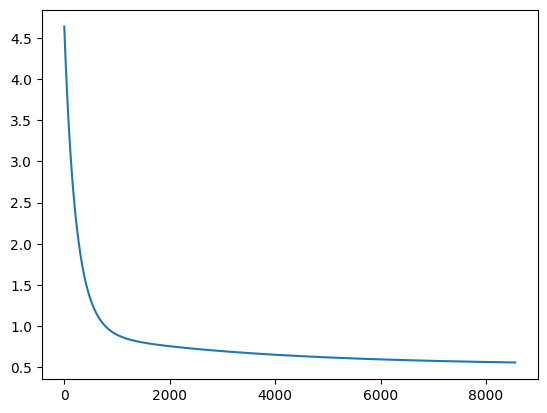

In [13]:
print(f'Ошибка на тестовой выборке: {test_error(X_test, y_test, w_fgd)}')
print('Значения весов', w_fgd.T)
plt.plot(errors_fgd);

Давайте теперь реализуем стохастический градиентный спуск.

In [16]:
ind = np.random.randint(X_train.shape[0])
ind

1685

In [19]:
def stochastic_gradient_descent(X, y, lr=0.001, tol=0.0001, max_steps=20000):
  # Добавьте в начало матрицы Х столбец из единиц
  X = np.hstack((np.ones((X.shape[0], 1)), X))
  np.random.seed(RANDOM_SEED)
  w_prev = np.random.rand(X.shape[1], 1)

  # Количество строк в матрице Х
  n = X.shape[0]
  errors = []

  for i in range(max_steps):
    # Создайте список из номера одного случайного объекта из выборки
    ind = np.random.randint(n)

    X_ind = X[ind, :].reshape(1,-1)
    y_ind = y[ind]

    # Значение градиента на шаге i
    grad = -2 * X_ind.T @ (y_ind -X_ind @ w_prev)
    # Шаг градиентного спуска
    w_new = w_prev - lr * grad

    errors.append(((y - X @ w_new)**2).sum() / n)
    # Условие, что норма разности векторов w_new и w_prev меньше tol
    if np.linalg.norm(w_new - w_prev) < tol:
      return w_new, errors
    else:
      w_prev = w_new

  return w_new, errors


In [20]:
%%time
w_sgd, errors_sgd = stochastic_gradient_descent(X_train, y_train)

print(f'Количество итераций: {len(errors_sgd)}')

Количество итераций: 244
CPU times: user 32.3 ms, sys: 35.3 ms, total: 67.6 ms
Wall time: 52.3 ms


Ошибка на тестовой выборке: 2.2276906805256025
Значения весов [[1.07960103 0.8941185  0.60013235 0.40334447 0.0432827  0.22142737
  0.03361304 0.70012945 0.67218878]]


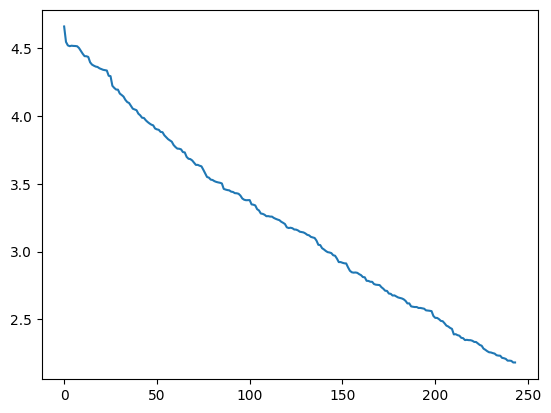

In [21]:
print(f'Ошибка на тестовой выборке: {test_error(X_test, y_test, w_sgd)}')
print('Значения весов', w_sgd.T)
plt.plot(errors_sgd);

Видно, что хоть мы и движемся вниз с точки зрения ошибки на обучающей выборке, мы останавливаемся слишком рано. Подумайте, почему так происходит. Попробуйте уменьшить значение параметра tol и посмотрите, что получится.

In [22]:
%%time
w_sgd, errors_sgd = stochastic_gradient_descent(X_train, y_train, tol=0.00001)

print(f'Количество итераций: {len(errors_sgd)}')

Количество итераций: 1260
CPU times: user 142 ms, sys: 69.5 ms, total: 211 ms
Wall time: 113 ms


Ошибка на тестовой выборке: 0.8302967114200617
Значения весов [[ 1.94675537  0.82909012  0.39157934  0.05928422 -0.06918601  0.13142379
  -0.01282355  0.4608064   0.49975588]]


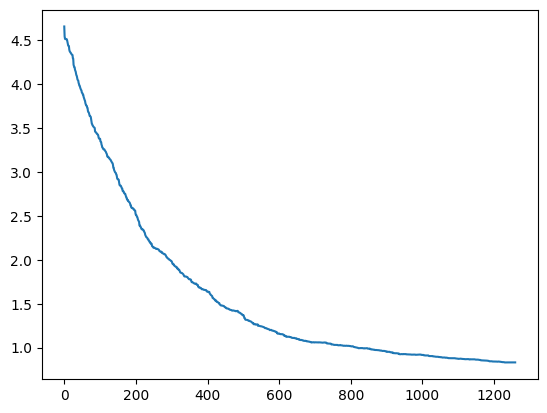

In [23]:
print(f'Ошибка на тестовой выборке: {test_error(X_test, y_test, w_sgd)}')
print('Значения весов', w_sgd.T)
plt.plot(errors_sgd);

Ошибка получилась значительно меньше, но и количество потребовавшихся шагов сильно увеличилось. Давайте теперь попробуем сделать что-то среднее между полным градиентным спуском и стохастическим градиентным спуском (Mini-batch),  добавим сохранение момента и динамический learning rate.

In [62]:
def momentum_gradient_descent(X, y, lr=0.001, tol=0.0001, batch_size=64, alpha=0.9, max_steps=20000):
  # Добавьте в начало матрицы Х столбец из единиц
  X = np.hstack((np.ones((X.shape[0], 1)), X))
  np.random.seed(RANDOM_SEED)
  w_prev = np.random.rand(X.shape[1], 1)

  # Количество строк в матрице Х
  n = X.shape[0]
  errors = []
  momentum = 0

  for i in range(max_steps):
    # Создайте список из batch_size штук случайных объектов из выборки
    ind = np.random.randint(X.shape[0], size=batch_size)

    X_ind = X[ind, :]
    y_ind = y[ind]

    # Значение градиента на шаге i
    grad = - 2 / n * X_ind.T @ (y_ind - X_ind @ w_prev)

    # Шаг градиентного спуска
    h = alpha * momentum + lr * grad
    w_new = w_prev - h

    errors.append(((y - X @ w_new)**2).sum() / n)
    # Условие, что норма разности векторов w_new и w_prev меньше tol
    if np.linalg.norm(w_new - w_prev) < tol:
      return w_new, errors
    else:
      w_prev = w_new
      momentum = h
      # Динамический learning rate
      lr = 0.01 / (i+1)**0.3

  return w_new, errors

In [63]:
%%time
w_mgd, errors_mgd = momentum_gradient_descent(X_train, y_train, tol=0.001)

print(f'Количество итераций: {len(errors_mgd)}')

Количество итераций: 1
CPU times: user 3.03 ms, sys: 3.87 ms, total: 6.91 ms
Wall time: 8 ms


In [ ]:
# Ошибка на тестовой выборке: 0.5351006091270314
# Значения весов [[ 2.0567588   0.88538669  0.11552066 -0.37842814  0.36108541  0.00758211
#   -0.13126665 -0.6894802  -0.68867091]]

Ошибка на тестовой выборке: 4.807050259168336
Значения весов [[0.37455486 0.95071366 0.73199196 0.59865229 0.15601378 0.15599742
  0.05808333 0.86617001 0.60111908]]


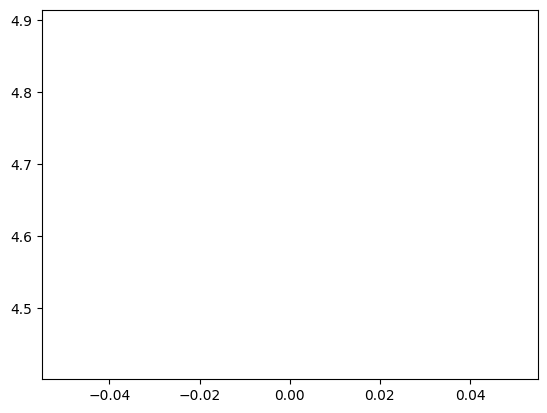

In [64]:
print(f'Ошибка на тестовой выборке: {test_error(X_test, y_test, w_mgd)}')
print('Значения весов', w_mgd.T)
plt.plot(errors_mgd);

Обратите внимание, что с помощью Momentum Mini-batch SGD мы получили даже лучше результат, чем при использовании метода LinearRegression из пакета sklearn. Однако, пришлось заменить значение параметра tol. Подумайте, почему так происходит, и поэкспериментируйте.